In [96]:
import pandas as pd 


In [97]:
WATER  = pd.read_csv('60.csv')


In [98]:
import pandas as pd

# Assuming your DataFrame is named df
WATER['INVDET_TXNDATE'] = pd.to_datetime(WATER['INVDET_TXNDATE'])  # Convert to datetime
WATER.set_index('INVDET_TXNDATE', inplace=True)  # Set as index
WATER['week'] = WATER.index.isocalendar().week  # Add ISO week number
WATER

,INVDET_PROCODE,sale,qty,week
INVDET_TXNDATE,,,,
2023-05-23,5160,29070.0,323,21
2023-05-24,5160,180.0,2,21
2023-05-25,5160,90.0,1,21
2023-05-26,5160,990.0,11,21
2023-05-30,5160,450.0,5,22
...,...,...,...,...
2025-06-01,5163,16800.0,48,22
2025-06-02,5163,11900.0,34,23
2025-06-03,5163,9450.0,27,23


In [99]:
import pandas as pd

# Step 1: Remove rows where qty <= 0
WATER = WATER[WATER['qty'] > 0]

# Step 2: Calculate IQR and bounds
Q1 = WATER['qty'].quantile(0.25)
Q3 = WATER['qty'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Step 3: Replace outliers with lower bound
WATER['qty'] = WATER['qty'].apply(
    lambda x: lower_bound if x < lower_bound or x > upper_bound else x
)


In [100]:
WATER.columns

Index(['INVDET_PROCODE', 'sale', 'qty', 'week'], dtype='object')

In [101]:
# Ensure the DataFrame is sorted by its datetime index
WATER = WATER.sort_index()

# Resample to daily sums
daily_series = WATER['qty'].resample('D').sum()

# Forecast horizon: ~4 months
horizon = 120
train = daily_series[:-horizon]
test = daily_series[-horizon:]


22:18:41 - cmdstanpy - INFO - Chain [1] start processing
22:18:42 - cmdstanpy - INFO - Chain [1] done processing


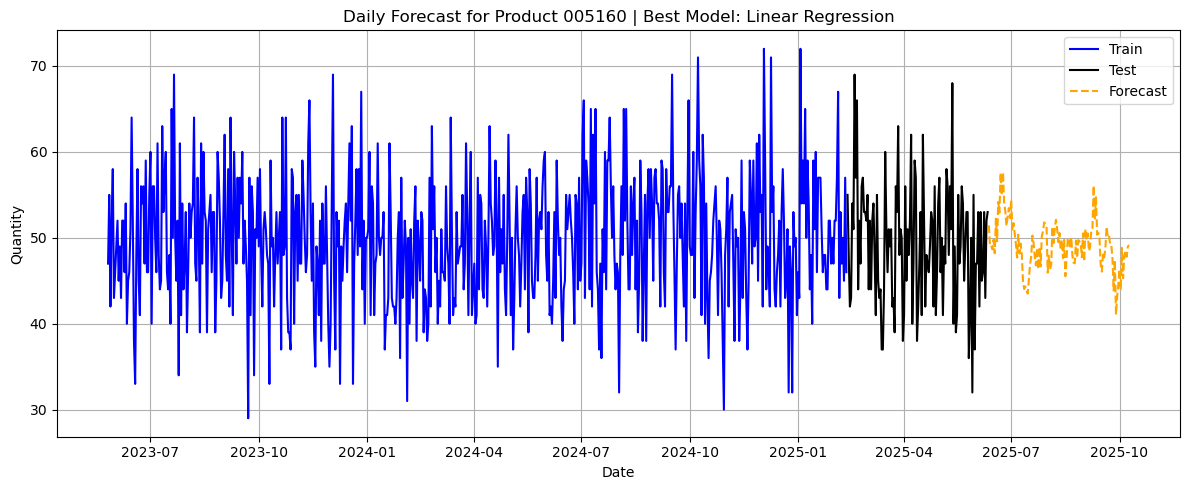

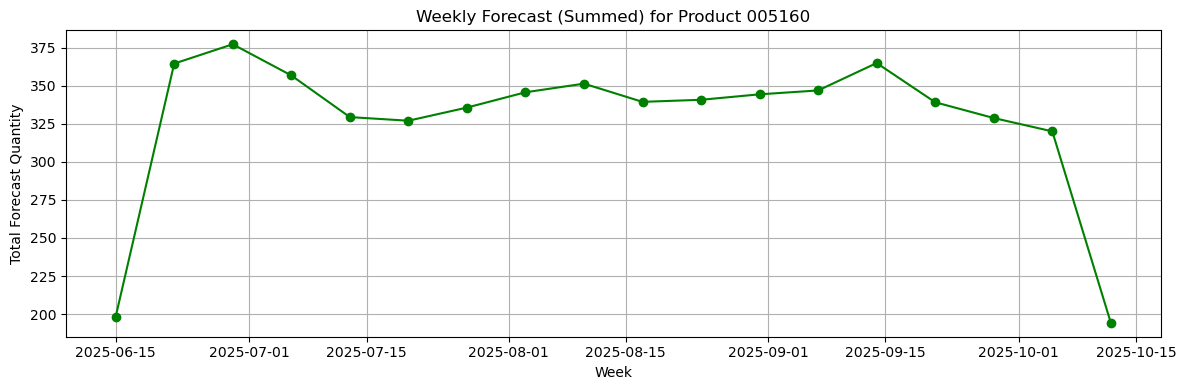

22:19:19 - cmdstanpy - INFO - Chain [1] start processing
22:19:19 - cmdstanpy - INFO - Chain [1] done processing


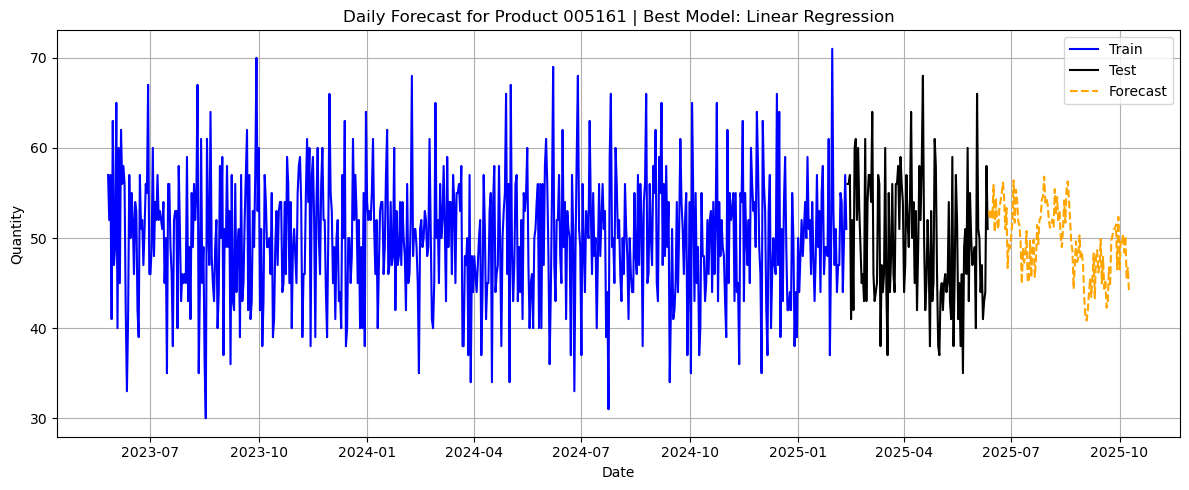

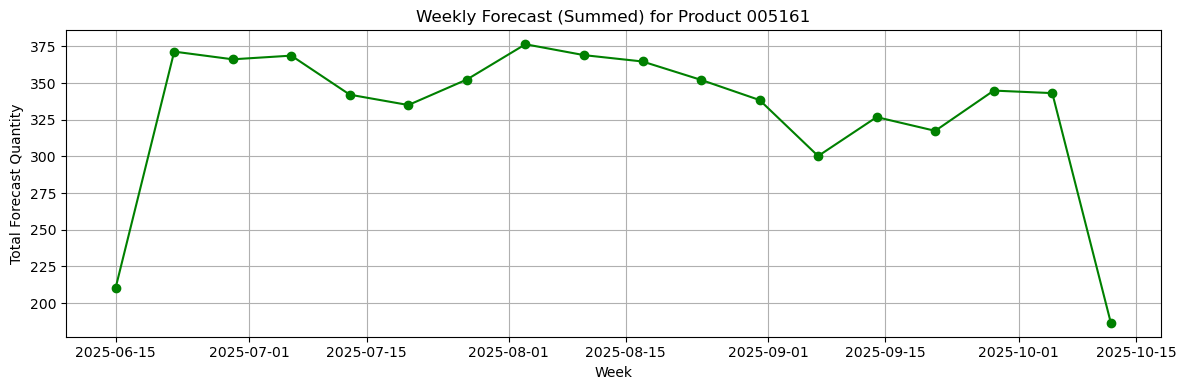

22:19:51 - cmdstanpy - INFO - Chain [1] start processing
22:19:51 - cmdstanpy - INFO - Chain [1] done processing


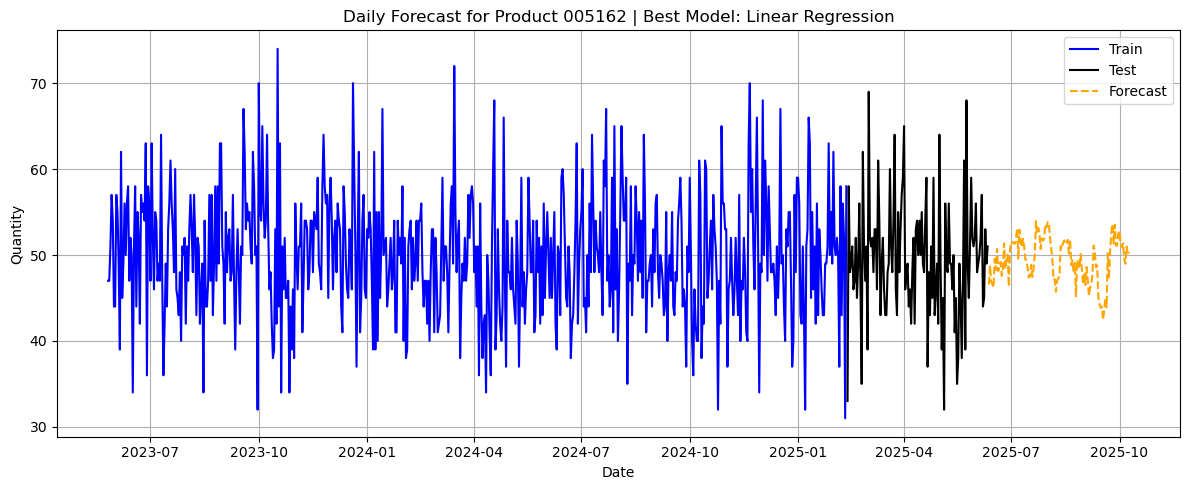

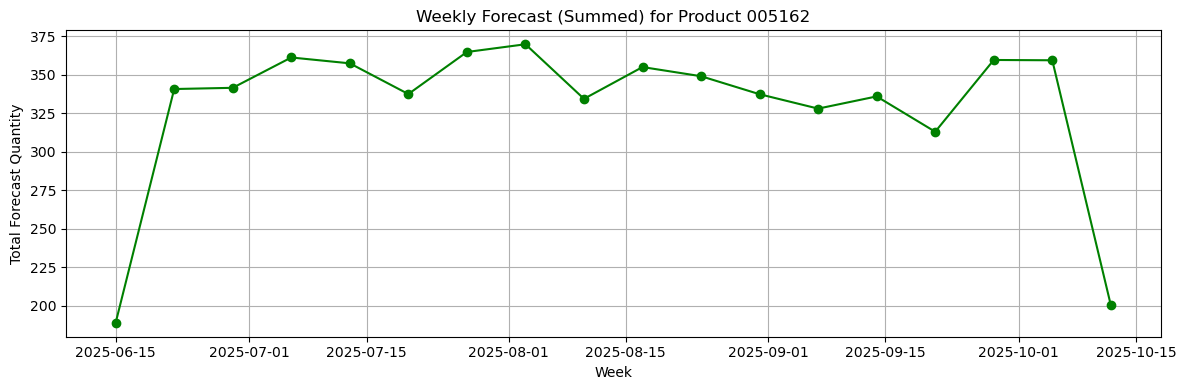

22:20:30 - cmdstanpy - INFO - Chain [1] start processing
22:20:30 - cmdstanpy - INFO - Chain [1] done processing


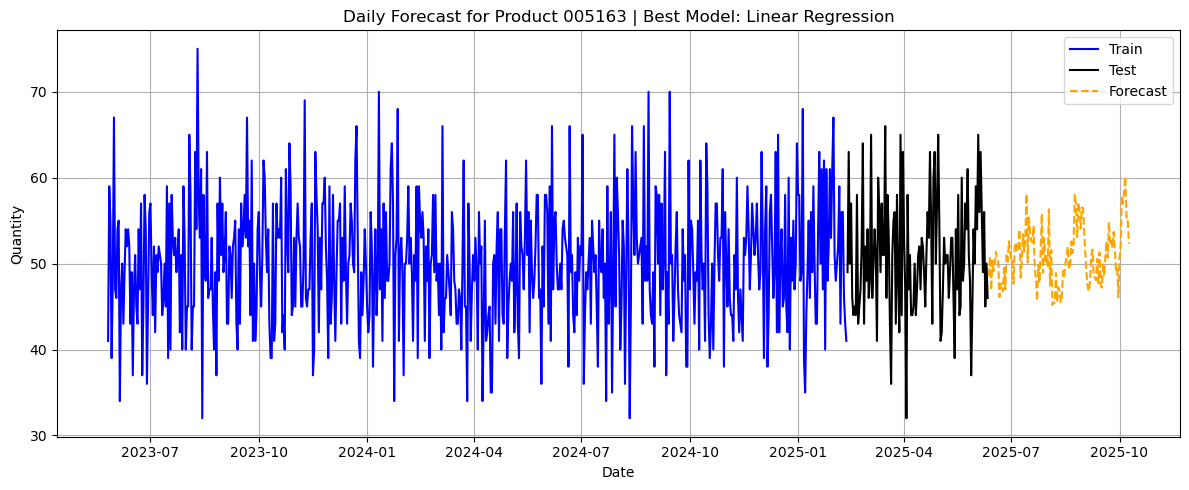

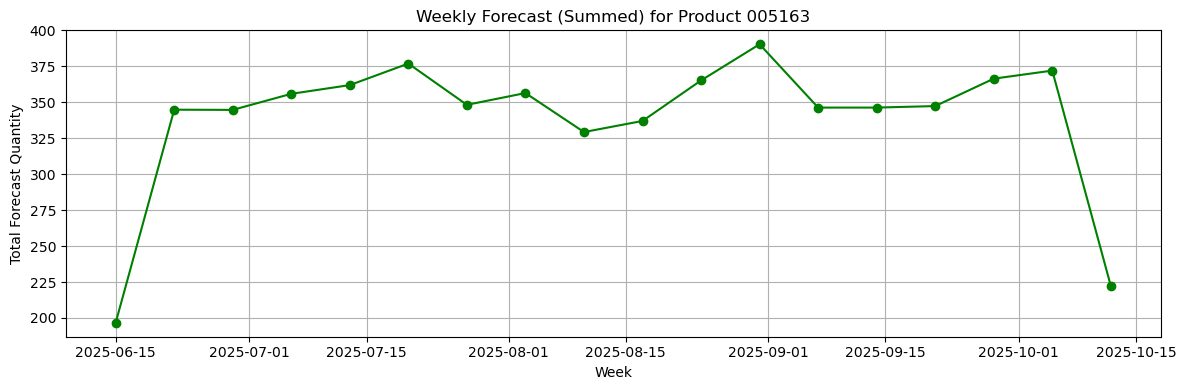

Forecast results saved to best_model_forecast_results_with_lstm.csv


,Product_Code,Date,Forecast_Qty,Forecast_with_Buffer_60%,Best_Model
0,005160,2025-06-12,51.45,82.32,Linear Regression
1,005160,2025-06-13,49.05,78.48,Linear Regression
2,005160,2025-06-14,49.09,78.55,Linear Regression
3,005160,2025-06-15,48.66,77.86,Linear Regression
4,005160,2025-06-16,49.78,79.64,Linear Regression


In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import warnings

warnings.filterwarnings('ignore')

# Simulate DRINKING_WATER_500ML dataset
np.random.seed(42)
date_range = pd.date_range(start='2023-05-26', end='2025-06-11')
product_codes = ['1' ,'2','3','4']
data = []

for code in product_codes:
    for date in date_range:
        data.append([date, code, np.random.poisson(50)])

WATER = pd.DataFrame(data, columns=['date', 'INVDET_PROCODE', 'qty'])
WATER.set_index('date', inplace=True)
WATER.index = pd.to_datetime(WATER.index)

forecast_results = []

def create_features(df):
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['dayofmonth'] = df.index.day
    df['month'] = df.index.month
    df['lag1'] = df['qty'].shift(1)
    df['rolling7'] = df['qty'].rolling(window=7).mean()
    return df.dropna()

def evaluate_model(y_true, y_pred):
    return mean_absolute_percentage_error(y_true, y_pred)

def build_lstm_model(train_data, n_input=14):
    X, y = [], []
    for i in range(len(train_data) - n_input):
        X.append(train_data[i:i+n_input])
        y.append(train_data[i+n_input])
    X, y = np.array(X), np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(n_input, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=20, verbose=0)
    return model, n_input

def forecast_lstm(model, history, n_input, steps):
    forecast = []
    for _ in range(steps):
        input_seq = np.array(history[-n_input:]).reshape((1, n_input, 1))
        next_val = model.predict(input_seq, verbose=0)[0][0]
        forecast.append(next_val)
        history.append(next_val)
    return np.array(forecast)

def forecast_product(df, product_code, horizon=120):
    df_product = df[df['INVDET_PROCODE'] == product_code].copy()
    df_product['date'] = pd.to_datetime(df_product.index)
    df_product = df_product.set_index('date').sort_index()
    daily_series = df_product['qty'].resample('D').sum()

    if len(daily_series) < horizon + 30:
        return

    train = daily_series[:-horizon]
    test = daily_series[-horizon:]

    # Prophet
    df_prophet = train.reset_index().rename(columns={'date': 'ds', 'qty': 'y'})
    model_prophet = Prophet()
    model_prophet.fit(df_prophet)
    future = model_prophet.make_future_dataframe(periods=horizon)
    forecast_prophet = model_prophet.predict(future)
    y_pred_prophet = forecast_prophet.set_index('ds')['yhat'][-horizon:]
    mape_prophet = evaluate_model(test, y_pred_prophet)

    # SARIMAX
    model_sarimax = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,7))
    result_sarimax = model_sarimax.fit(disp=False)
    y_pred_sarimax = result_sarimax.predict(start=test.index[0], end=test.index[-1])
    mape_sarimax = evaluate_model(test, y_pred_sarimax)

    # XGBoost
    df_xgb = daily_series.to_frame(name='qty')
    df_xgb = create_features(df_xgb)
    X = df_xgb.drop('qty', axis=1)
    y = df_xgb['qty']
    X_train, X_test = X[:-horizon], X[-horizon:]
    y_train, y_test = y[:-horizon], y[-horizon:]

    model_xgb = XGBRegressor()
    model_xgb.fit(X_train, y_train)
    y_pred_xgb = model_xgb.predict(X_test)
    mape_xgb = evaluate_model(y_test, y_pred_xgb)

    # Linear Regression
    model_lr = LinearRegression()
    model_lr.fit(X_train, y_train)
    y_pred_lr = model_lr.predict(X_test)
    mape_lr = evaluate_model(y_test, y_pred_lr)

    # LSTM
    scaler = MinMaxScaler()
    scaled_train = scaler.fit_transform(train.values.reshape(-1, 1)).flatten()
    lstm_model, n_input = build_lstm_model(list(scaled_train))
    forecast_scaled = forecast_lstm(lstm_model, list(scaled_train), n_input, horizon)
    forecast_lstm_series = pd.Series(scaler.inverse_transform(forecast_scaled.reshape(-1, 1)).flatten(), index=test.index)
    mape_lstm = evaluate_model(test, forecast_lstm_series)

    model_mape_scores = {
        "Prophet": mape_prophet,
        "SARIMAX": mape_sarimax,
        "XGBoost": mape_xgb,
        "Linear Regression": mape_lr,
        "LSTM": mape_lstm
    }
    best_model_name = min(model_mape_scores, key=model_mape_scores.get)

    future_days = pd.date_range(start=daily_series.index[-1] + pd.Timedelta(days=1), periods=horizon)

    if best_model_name == "Prophet":
        final_forecast = forecast_prophet.set_index('ds')['yhat'][-horizon:]
    elif best_model_name == "SARIMAX":
        final_model = SARIMAX(daily_series, order=(1,1,1), seasonal_order=(1,1,1,7)).fit(disp=False)
        final_forecast = final_model.predict(start=future_days[0], end=future_days[-1])
    elif best_model_name == "XGBoost":
        last_part = daily_series.to_frame(name='qty').copy()
        last_part = pd.concat([last_part, pd.DataFrame(index=future_days)], axis=0)
        last_part = create_features(last_part)
        future_X = last_part[-horizon:].drop('qty', axis=1)
        final_forecast = model_xgb.predict(future_X)
        final_forecast = pd.Series(final_forecast, index=future_days)
    elif best_model_name == "Linear Regression":
        last_part = daily_series.to_frame(name='qty').copy()
        last_part = pd.concat([last_part, pd.DataFrame(index=future_days)], axis=0)
        last_part = create_features(last_part)
        future_X = last_part[-horizon:].drop('qty', axis=1)
        final_forecast = model_lr.predict(future_X)
        final_forecast = pd.Series(final_forecast, index=future_days)
    elif best_model_name == "LSTM":
        full_series_scaled = scaler.fit_transform(daily_series.values.reshape(-1, 1)).flatten()
        lstm_model, n_input = build_lstm_model(list(full_series_scaled))
        forecast_scaled = forecast_lstm(lstm_model, list(full_series_scaled), n_input, horizon)
        forecast = scaler.inverse_transform(forecast_scaled.reshape(-1, 1)).flatten()
        final_forecast = pd.Series(forecast, index=future_days)

    for date, value in final_forecast.items():
        forecast_results.append({
            'Product_Code': product_code,
            'Date': date,
            'Forecast_Qty': round(value, 2),
            'Forecast_with_Buffer_60%': round(value * 1.6, 2),
            'Best_Model': best_model_name
        })

    # Plot daily forecast
    plt.figure(figsize=(12, 5))
    plt.plot(train.index, train, label='Train', color='blue')
    plt.plot(test.index, test, label='Test', color='black')
    plt.plot(final_forecast.index, final_forecast, label='Forecast', linestyle='--', color='orange')
    plt.title(f"Daily Forecast for Product {product_code} | Best Model: {best_model_name}")
    plt.xlabel("Date")
    plt.ylabel("Quantity")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot weekly forecast
    weekly_forecast = final_forecast.resample('W').sum()
    plt.figure(figsize=(12, 4))
    plt.plot(weekly_forecast.index, weekly_forecast, marker='o', linestyle='-', color='green')
    plt.title(f"Weekly Forecast (Summed) for Product {product_code}")
    plt.xlabel("Week")
    plt.ylabel("Total Forecast Quantity")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Run forecast for each product
for code in DRINKING_WATER_500ML['INVDET_PROCODE'].unique():
    forecast_product(DRINKING_WATER_500ML, code)

# Save forecast to CSV
forecast_df = pd.DataFrame(forecast_results)
csv_path = "best_model_forecast_results_with_lstm.csv"
forecast_df.to_csv(csv_path, index=False)
print(f"Forecast results saved to {csv_path}")

# Show sample of final result
forecast_df.head()


In [106]:
# Ensure Date column is datetime
forecast_df['Date'] = pd.to_datetime(forecast_df['Date'])

# Filter only the next 4 months from the last date in original dataset
start_date = pd.to_datetime('2025-06-12')
end_date = start_date + pd.DateOffset(months=4)
filtered_df = forecast_df[(forecast_df['Date'] >= start_date) & (forecast_df['Date'] <= end_date)]

# Group and save forecasts
for product_code in filtered_df['Product_Code'].unique():
    df_product = filtered_df[filtered_df['Product_Code'] == product_code].copy()
    
    # Weekly forecast
    weekly_forecast = df_product.resample('W-MON', on='Date').sum(numeric_only=True).reset_index()
    weekly_forecast['Forecast_With_Buffer'] = weekly_forecast['Forecast_Qty'] * 1.6

    # Add 'With_Octane' column based on specific product codes
    if product_code == '1':
        weekly_forecast['With_Octane'] = weekly_forecast['Forecast_With_Buffer'] + 240
    elif product_code == '2':
        weekly_forecast['With_Octane'] = weekly_forecast['Forecast_With_Buffer'] + 225
    else:
        weekly_forecast['With_Octane'] = weekly_forecast['Forecast_With_Buffer']

    weekly_path = f"weekly_forecast_{product_code}.xlsx"
    weekly_forecast.to_excel(weekly_path, index=False)
    print(f"Saved weekly forecast (with buffer and octane) for product {product_code} to {weekly_path}")
    
    # Monthly forecast
    monthly_forecast = df_product.resample('M', on='Date').sum(numeric_only=True).reset_index()
    monthly_path = f"monthly_forecast_{product_code}.xlsx"
    monthly_forecast.to_excel(monthly_path, index=False)
    print(f"Saved monthly forecast for product {product_code} to {monthly_path}")


Saved weekly forecast (with buffer and octane) for product 005160 to weekly_forecast_005160.xlsx
Saved monthly forecast for product 005160 to monthly_forecast_005160.xlsx
Saved weekly forecast (with buffer and octane) for product 005161 to weekly_forecast_005161.xlsx
Saved monthly forecast for product 005161 to monthly_forecast_005161.xlsx
Saved weekly forecast (with buffer and octane) for product 005162 to weekly_forecast_005162.xlsx
Saved monthly forecast for product 005162 to monthly_forecast_005162.xlsx
Saved weekly forecast (with buffer and octane) for product 005163 to weekly_forecast_005163.xlsx
Saved monthly forecast for product 005163 to monthly_forecast_005163.xlsx


In [109]:
import pandas as pd

# Ensure Date column is datetime
forecast_df['Date'] = pd.to_datetime(forecast_df['Date'])

# Filter only the next 4 months from the last date in original dataset
start_date = pd.to_datetime('2025-06-12')
end_date = start_date + pd.DateOffset(months=4)
filtered_df = forecast_df[(forecast_df['Date'] >= start_date) & (forecast_df['Date'] <= end_date)]

# Group and save forecasts
for product_code in filtered_df['Product_Code'].unique():
    df_product = filtered_df[filtered_df['Product_Code'] == product_code].copy()
    
    # Weekly forecast
    weekly_forecast = df_product.resample('W-MON', on='Date').sum(numeric_only=True).reset_index()
    weekly_forecast['Forecast_With_Buffer'] = weekly_forecast['Forecast_Qty'] * 1.6

    # Add 'With_Octane' column based on specific product codes
    if product_code == '1':
        weekly_forecast['With_Octane'] = weekly_forecast['Forecast_With_Buffer'] + 240
    elif product_code == '2':
        weekly_forecast['With_Octane'] = weekly_forecast['Forecast_With_Buffer'] + 225
    else:
        weekly_forecast['With_Octane'] = weekly_forecast['Forecast_With_Buffer']

    weekly_path = f"weekly_forecast_{product_code}.xlsx"
    weekly_forecast.to_excel(weekly_path, index=False)
    print(f"Saved weekly forecast (with buffer and octane) for product {product_code} to {weekly_path}")
    
    # Monthly forecast
    monthly_forecast = df_product.resample('M', on='Date').sum(numeric_only=True).reset_index()

   # Add Month column to both for merging
    weekly_forecast['Month'] = weekly_forecast['Date'].dt.to_period('M').dt.to_timestamp()
    monthly_forecast['Month'] = monthly_forecast['Date'].dt.to_period('M').dt.to_timestamp()

    # Get monthly totals of With_Octane from weekly forecast
    monthly_totals = (
        weekly_forecast
        .groupby('Month', as_index=False)['With_Octane']
        .sum()
        .rename(columns={'With_Octane': 'Monthly_Requirement'})
    )

    # Merge totals into monthly forecast
    monthly_forecast = monthly_forecast.merge(monthly_totals, on='Month', how='left').drop(columns=['Month'])

    # Save monthly forecast
    monthly_path = f"monthly_forecast_{product_code}.xlsx"
    monthly_forecast.to_excel(monthly_path, index=False)
    print(f"Saved monthly forecast (with monthly requirement) for product {product_code} to {monthly_path}")














Saved weekly forecast (with buffer and octane) for product 005160 to weekly_forecast_005160.xlsx
Saved monthly forecast (with monthly requirement) for product 005160 to monthly_forecast_005160.xlsx
Saved weekly forecast (with buffer and octane) for product 005161 to weekly_forecast_005161.xlsx
Saved monthly forecast (with monthly requirement) for product 005161 to monthly_forecast_005161.xlsx
Saved weekly forecast (with buffer and octane) for product 005162 to weekly_forecast_005162.xlsx
Saved monthly forecast (with monthly requirement) for product 005162 to monthly_forecast_005162.xlsx
Saved weekly forecast (with buffer and octane) for product 005163 to weekly_forecast_005163.xlsx
Saved monthly forecast (with monthly requirement) for product 005163 to monthly_forecast_005163.xlsx
